In [2]:
from src.modelmodule.seg import SegModel
from src.datamodule.seg import SegDataModule
from pytorch_lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
import torch
from omegaconf import OmegaConf, DictConfig
import hydra

# 用于初始化 Hydra 并且合成配置的函数
def init_hydra():
    with hydra.initialize(config_path="run/conf", version_base="1.2"):
        # 这里我们使用 compose 而不是 hydra.main
        cfg = hydra.compose(config_name="train")
        return cfg

# 执行代码
cfg = init_hydra()

cfg.accelerator = 'cpu'
cfg.duration = 17280
cfg.downsample_rate = 12
cfg.batch_size = 3
cfg.sigma = 5
cfg.decoder.dropout=0.2 
cfg.post_process.score_th=0.502 
cfg.post_process.distance=64 
cfg.loss=DictConfig({"name": "MSE"})
# cfg.feature_extractor=DictConfig({
#     "name": "PANNsFeatureExtractor",
#     "base_filters": 64,
#     "kernel_sizes": [
#       32,
#       16,
#       3
#     ],
#     "stride": 3,
#     "sigmoid": True,
#     "reinit": True,
#     "win_length": None
#   })
cfg.decoder.num_layers = 4
cfg.model.unet_class="DeepLabV3Plus" 
cfg.model.encoder_name="efficientnet-b7"


# additional_cfg = OmegaConf.load(f"run/conf/feature_extractor/{cfg.feature_extractor}.yaml")
# print(OmegaConf.merge(cfg, additional_cfg))

seed_everything(cfg.seed)
print(cfg)
# 初始化 lightning 数据模块和模型
datamodule = SegDataModule(cfg)
model = SegModel(
    cfg, datamodule.valid_event_df, len(cfg.features), len(cfg.labels), cfg.duration
)
# weight_path = 'output/train/exp005/single/child-mind-institute-detect-sleep-states/itphhvr1/checkpoints/epoch=25-step=3094.ckpt'
# weight_path = 'output/train/exp005/single/best_model.pth'
# weight_path = 'output/train/exp024/run1/child-mind-institute-detect-sleep-states/lo9s9uts/checkpoints/epoch=14-step=5715.ckpt'
weight_path = 'output/train/exp035/single/best_model.pth'
# model.load_state_dict(torch.load(weight_path)['state_dict'])
ckpt = torch.load(weight_path)
ret={}
for k,v in ckpt.items():
    # ret[k.replace("model.", "", 1)] = v
    ret["model."+k] = v
model.load_state_dict(ret)
spec2dcnn = model.model
# spec2dcnn.load_state_dict(torch.load(weight_path)['state_dict']['model'])

/home/ljb/miniconda3/envs/new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


{'model_sigmod': False, 'output_sigmod': False, 'output_clip': False, 'seed': 42, 'exp_name': 'dummy', 'duration': 17280, 'downsample_rate': 12, 'upsample_rate': 1, 'epoch': 50, 'batch_size': 3, 'num_workers': 24, 'accelerator': 'cpu', 'use_amp': True, 'debug': False, 'gradient_clip_val': 0.1, 'accumulate_grad_batches': 1, 'monitor': 'val_score', 'monitor_mode': 'max', 'check_val_every_n_epoch': 1, 'offset': 10, 'sigma': 5, 'bg_sampling_rate': 0.5, 'augmentation': {'mixup_prob': 0.01, 'mixup_alpha': 0.4, 'cutmix_prob': 0.01, 'cutmix_alpha': 0.4}, 'post_process': {'score_th': 0.502, 'distance': 64}, 'labels': ['awake', 'event_onset', 'event_wakeup'], 'features': ['anglez', 'enmo', 'hour_sin', 'hour_cos'], 'optimizer': {'lr': 0.001}, 'scheduler': {'num_warmup_steps': 0}, 'loss': {'name': 'MSE'}, 'dir': {'data_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/data', 'processed_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/processed_data', 'output_dir': '/

RuntimeError: Error(s) in loading state_dict for SegModel:
	Missing key(s) in state_dict: "model.feature_extractor.extractors.0.transformer_encoder.layers.2.self_attn.in_proj_weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.self_attn.in_proj_bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.self_attn.out_proj.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.self_attn.out_proj.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.linear1.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.linear1.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.linear2.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.linear2.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.norm1.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.norm1.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.norm2.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.2.norm2.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.self_attn.in_proj_weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.self_attn.in_proj_bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.self_attn.out_proj.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.self_attn.out_proj.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.linear1.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.linear1.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.linear2.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.linear2.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.norm1.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.norm1.bias", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.norm2.weight", "model.feature_extractor.extractors.0.transformer_encoder.layers.3.norm2.bias", "model.feature_extractor.extractors.2.lstm.weight_ih_l2", "model.feature_extractor.extractors.2.lstm.weight_hh_l2", "model.feature_extractor.extractors.2.lstm.bias_ih_l2", "model.feature_extractor.extractors.2.lstm.bias_hh_l2", "model.feature_extractor.extractors.2.lstm.weight_ih_l2_reverse", "model.feature_extractor.extractors.2.lstm.weight_hh_l2_reverse", "model.feature_extractor.extractors.2.lstm.bias_ih_l2_reverse", "model.feature_extractor.extractors.2.lstm.bias_hh_l2_reverse", "model.feature_extractor.extractors.2.lstm.weight_ih_l3", "model.feature_extractor.extractors.2.lstm.weight_hh_l3", "model.feature_extractor.extractors.2.lstm.bias_ih_l3", "model.feature_extractor.extractors.2.lstm.bias_hh_l3", "model.feature_extractor.extractors.2.lstm.weight_ih_l3_reverse", "model.feature_extractor.extractors.2.lstm.weight_hh_l3_reverse", "model.feature_extractor.extractors.2.lstm.bias_ih_l3_reverse", "model.feature_extractor.extractors.2.lstm.bias_hh_l3_reverse". 
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder_layer.linear1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder_layer.linear1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder_layer.linear2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder.layers.0.linear1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder.layers.0.linear1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder.layers.0.linear2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder.layers.1.linear1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder.layers.1.linear1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for model.feature_extractor.extractors.0.transformer_encoder.layers.1.linear2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for model.feature_extractor.extractors.1.cnn_feature_extractor.spec_conv.0.weight: copying a param with shape torch.Size([64, 4, 128]) from checkpoint, the shape in current model is torch.Size([64, 4, 144]).
	size mismatch for model.feature_extractor.extractors.1.cnn_feature_extractor.spec_conv.1.weight: copying a param with shape torch.Size([64, 4, 64]) from checkpoint, the shape in current model is torch.Size([64, 4, 96]).
	size mismatch for model.feature_extractor.extractors.1.cnn_feature_extractor.spec_conv.2.weight: copying a param with shape torch.Size([64, 4, 16]) from checkpoint, the shape in current model is torch.Size([64, 4, 24]).

In [ ]:
feature_extractor = spec2dcnn.feature_extractor
encoder = spec2dcnn.encoder
decoder = spec2dcnn.decoder

In [ ]:
train_dl = datamodule.train_dataloader()
batch = next(iter(train_dl)) #dict_keys(['series_id', 'feature', 'label'])

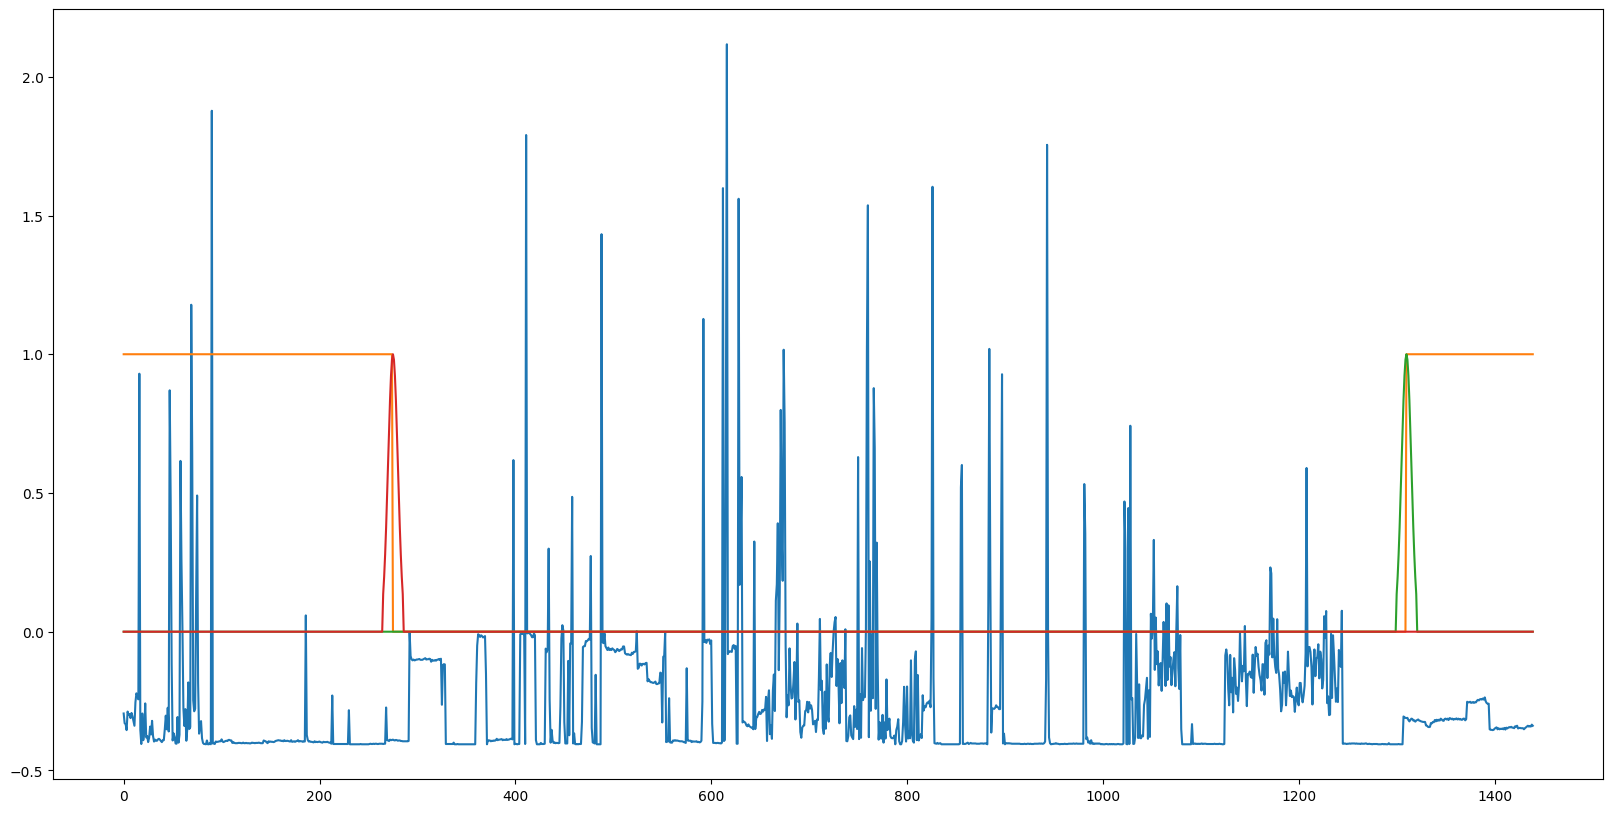

In [ ]:
idx = 1
s_id = batch['series_id'][idx]
x = batch['feature'][idx:idx+2]
y = batch['label'][idx]
fig = plt.figure(figsize=(20, 10))
plt.plot(x[idx, 1, ::cfg.downsample_rate])
plt.plot(y)
plt.show()

torch.Size([2, 10, 64, 1440])


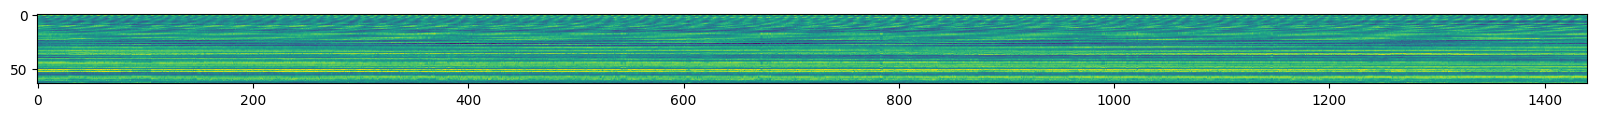

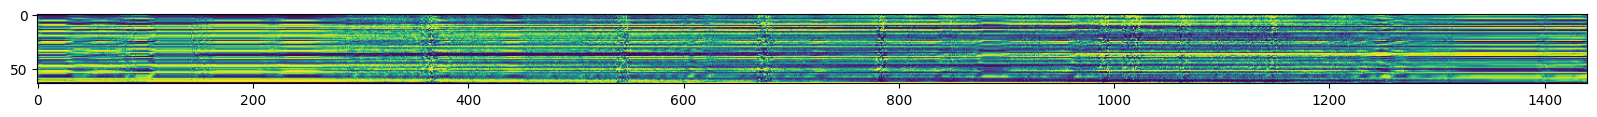

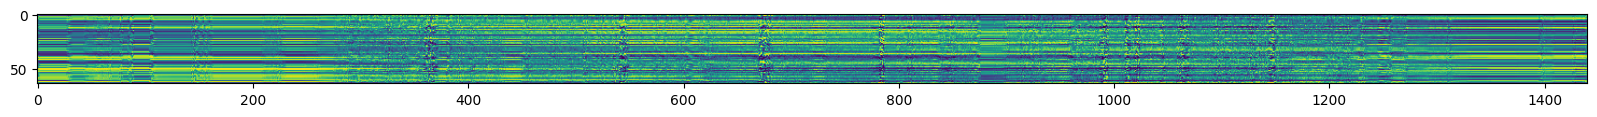

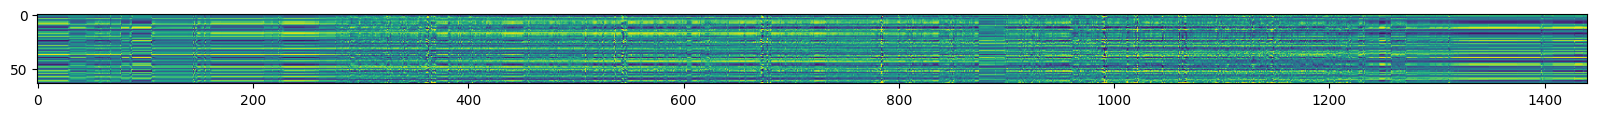

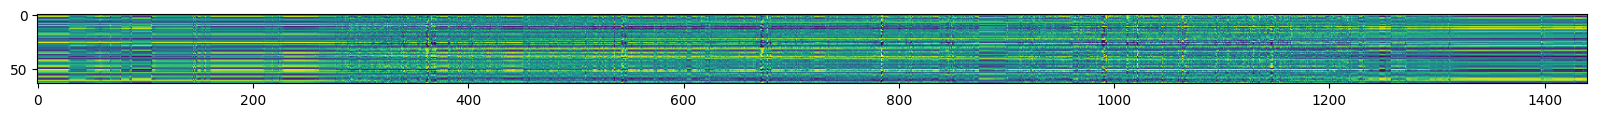

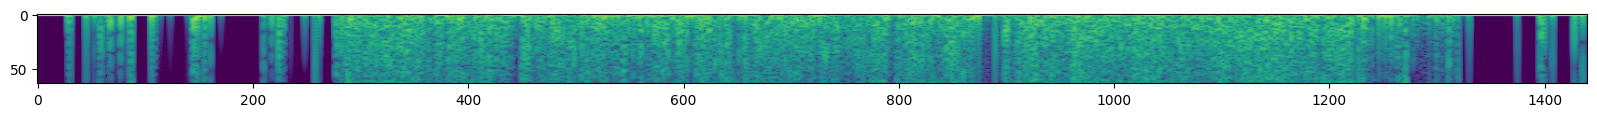

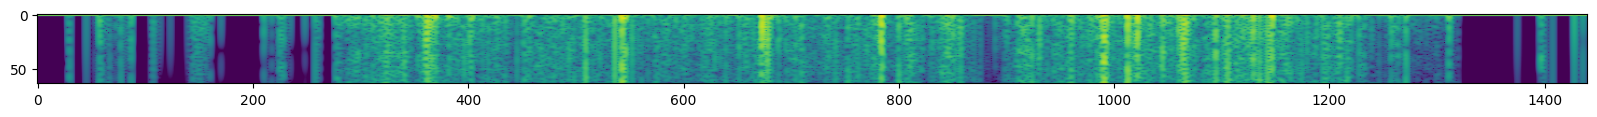

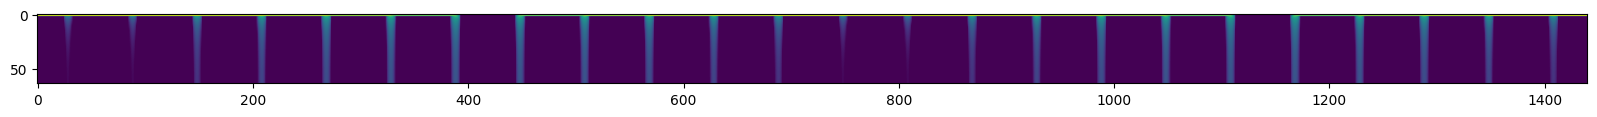

torch.Size([2, 64, 1440])


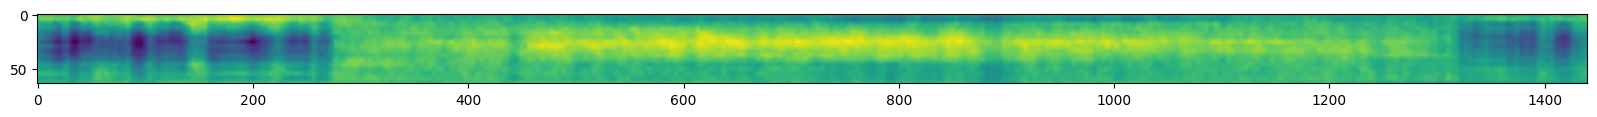

torch.Size([1440, 3])


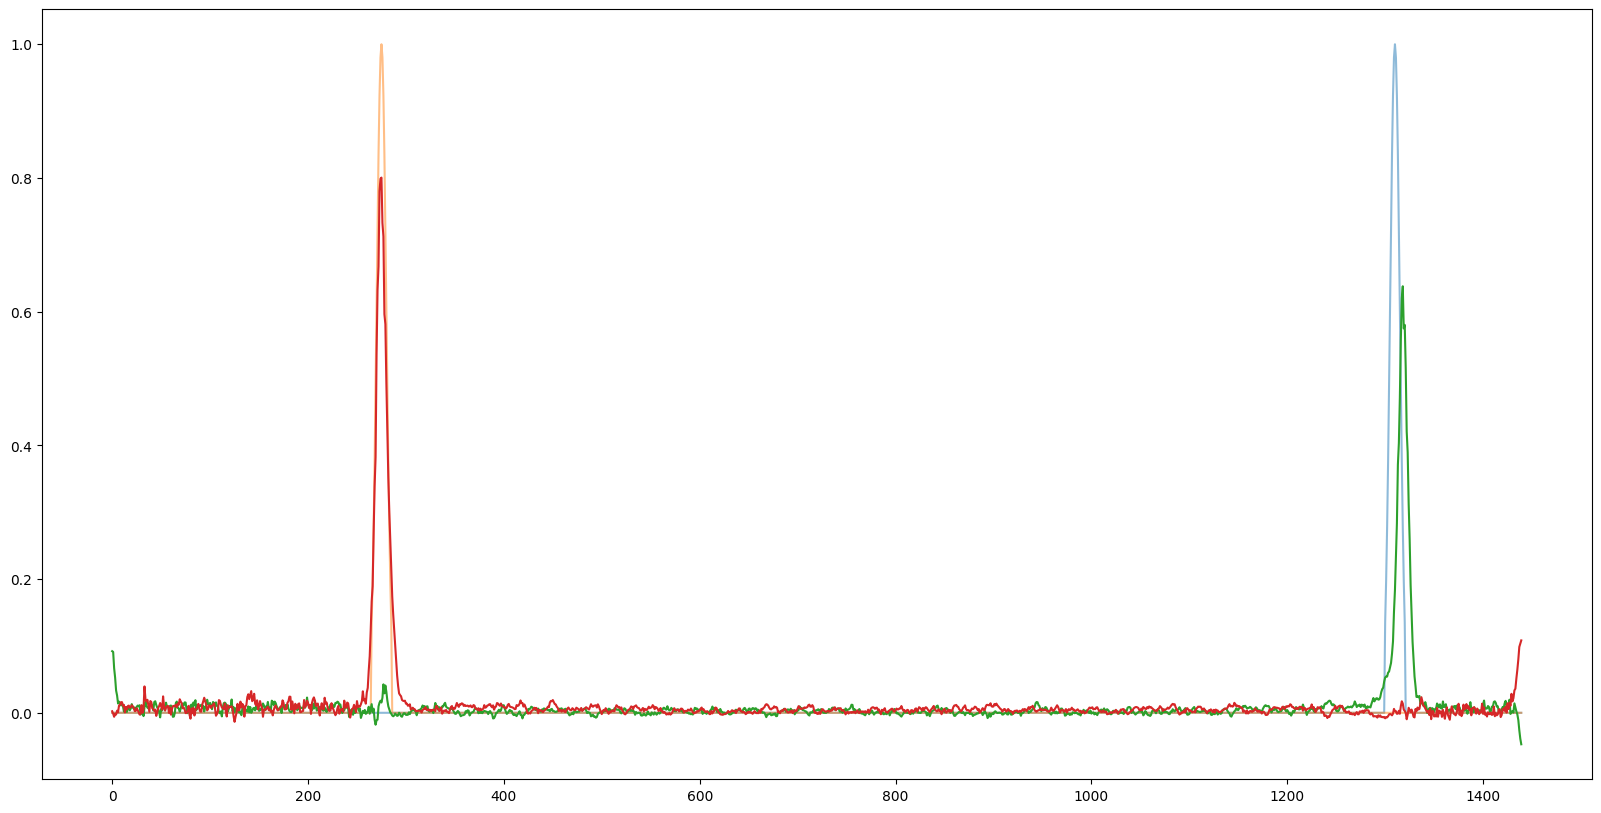

In [ ]:
out = feature_extractor(x)  # (batch_size, n_channels, height, n_timesteps)
print(out.shape)
for i in range(8):
    plt.figure(figsize=(20, 10))
    plt.imshow(out[0, i, :, :].detach().numpy())
    plt.show()
out = encoder(out).squeeze(1)  # (batch_size, height, n_timesteps)
print(out.shape)
plt.figure(figsize=(20, 10))
plt.imshow(out[0, :, :].detach().numpy())
plt.show()
logits = decoder(out)[0]  # (batch_size, n_classes, n_timesteps)
print(logits.shape)
plt.figure(figsize=(20, 10))
plt.plot(y[:,1:], alpha=0.5)
for i in range(1,3):
    plt.plot(logits[:, i].detach().numpy())

plt.show()

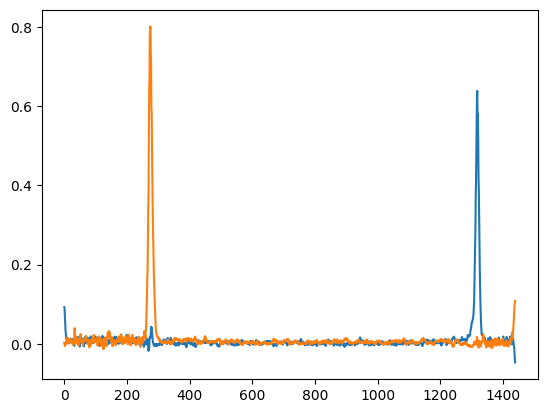

In [ ]:
pred = logits
pred = pred.detach().numpy()
plt.plot(pred[::1,1:])
pred_withsigmoid = logits.sigmoid()
pred_withsigmoid = pred_withsigmoid.detach().numpy()
# plt.plot(pred_withsigmoid[::1,1:])
plt.show()

In [ ]:
from scipy.signal import find_peaks
dim = 0

find_peaks(pred[:,dim], height=0.02, threshold=0.01, distance=64)

NameError: name 'pred' is not defined

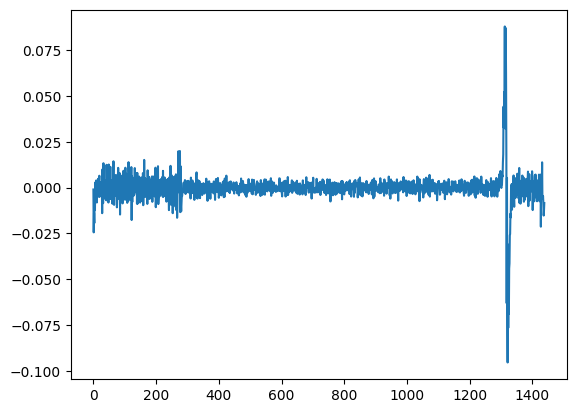

In [ ]:
import numpy as np
plt.plot(np.diff(pred[:,1]))
plt.show()

In [ ]:
pred

array([[ 0.6271157 ,  0.09216262,  0.00233215],
       [ 0.8062615 ,  0.09112282, -0.00123716],
       [ 0.87222147,  0.06668856, -0.00592686],
       ...,
       [ 0.8443974 , -0.02614451,  0.09858171],
       [ 0.761487  , -0.03864503,  0.1033719 ],
       [ 0.63665956, -0.04707833,  0.10830289]], dtype=float32)

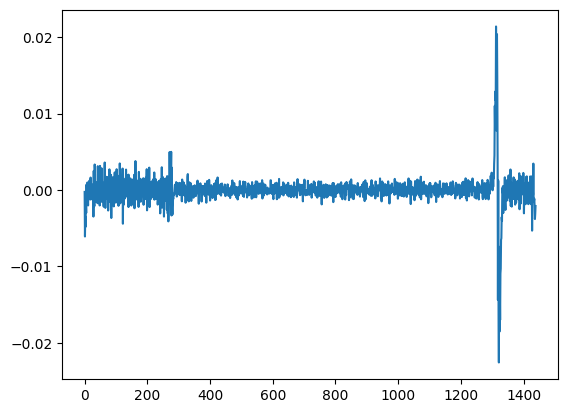

In [ ]:
import numpy as np
plt.plot(np.diff(pred_withsigmoid[:,1]))
plt.show()

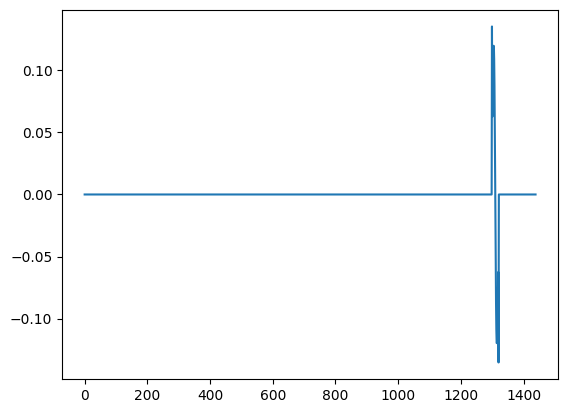

In [ ]:
plt.plot(np.diff(y[:,1]))
plt.show()